# Prices EDA

In this Notebook, we're going to examine how time-series data is constructed and distributed. We know that gas stations in Germany are required to report any change in their petrol prices in (almost) real-time. This means that data isn't generated centrally but is decentralized across approximately 16,000 instances. We observe that the API creates some batched timestamps rather than a single timestamp for every observed price change, but this doesn't provide much help. We encounter three main issues with the data:

* It's not uniformly sampled, which means that not every timestamp represents each gas station. In fact, each timestamp includes only a relatively small number of price changes, although more than one.
* Timestamps aren't equidistant, which is to be expected as gas stations can change their prices at will and at any time. Sometimes prices change 10 times per hour, and sometimes only once a day.
* In addition to the irregular time-scale, there's no rule dictating when gas stations sell gas. They might be closed for an entire day, have varying opening hours, or never close at all. They might also run out of product and stop selling entirely.

We're trying to investigate the details of the outlined problems and find solutions to pre-process our data for a baseline model. Note that there are models capable of handling irregular data. We will explore these further down the line. However, in a first step, our goal is to resample the data as efficiently as possible and create a regular panel. To do this, we need to:

* Find reasonable time-bins for the report. If we make these too granular, the dataset will bloat exponentially, making it computationally unreasonable.
* If the bins are too large, we lose too much information. Our goal is to observe and predict impulse responses from neighboring gas stations. Large bins would falsely imply that events are happening simultaneously, which they aren't, as the data generation process (DGP) is decentralized.
* This process will create many sparse tables, which will need to be filled with the current prices of each gas station at each timestamp. These prices correspond to the last price the respective station set.

Especially the last point is quite unfortunate but necessary for classical models or "simpler" ML models to handle the data. However, it doesn't really add any information that wasn't in the original dataset, yet it needs to be computed. Our goal is to find a model that can handle this irregular data without the need for resampling. One way to tackle this could be the creation of time distances as features, which we will also investigate in this notebook.

In [26]:
import pandas as pd
import numpy as np
import datetime as dt
import random
import pyarrow

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from config.paths import ROOT_DIR, SAMPLE_DIR, PRICES_DIR

import src.fileutils as files
import src.visualization as viz

In [6]:
stations_info_file = ROOT_DIR / 'data' / 'stations.csv'
sample_file_location = SAMPLE_DIR
sample_price_location = SAMPLE_DIR / 'prices'

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

## Initial EDA and cleaning

But let's first take a step back and start with some basic EDA by importing a random day from our data.

In [7]:
# prices_sample = pd.read_csv(files.pick_random_csv(PRICES_DIR, random_state=RSEED))
prices_sample = pd.read_csv(PRICES_DIR / '2021' / '08' / '2021-08-09-prices.csv')

display(prices_sample.sample(3, random_state=RSEED))
display(viz.nice_summary(prices_sample))

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
195420,2021-08-09 15:34:06+02,c83474cf-5736-43eb-adc5-91ccb28bb5e8,1.359,1.599,1.539,3,3,3
78104,2021-08-09 10:11:06+02,001e3111-58c3-4e99-b6d5-a8f244b579f3,1.449,1.659,1.599,0,1,1
269760,2021-08-09 18:34:08+02,9b7b1b32-4532-4e99-8b29-9edb64d44a0a,1.359,1.599,1.539,0,1,1


,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,date,object,1257,331244,-,-,0,-,-,-,-,-,-,-
1,station_uuid,object,14999,331244,-,-,0,-,-,-,-,-,-,-
2,diesel,float64,181,331244,-,-,33,1.39,0.05,-0.0,1.36,1.39,1.42,2.0
3,e5,float64,181,331244,-,-,4769,1.6,0.2,-0.0,1.59,1.62,1.65,2.07
4,e10,float64,176,331244,-,-,14572,1.49,0.32,-0.0,1.53,1.56,1.59,2.03
5,dieselchange,int64,4,331244,-,-,65371,0.89,0.61,0.0,1.0,1.0,1.0,3.0
6,e5change,int64,4,331244,-,-,67445,0.89,0.61,0.0,1.0,1.0,1.0,3.0
7,e10change,int64,4,331244,-,-,75399,0.86,0.61,0.0,1.0,1.0,1.0,3.0


* During August 9th 2021, a total of 331,244 price changes have been reported. As we can see from the sample, multiple prices can be changed at the same time.
* The API batched this into 1257 different timestamps for that day.
* 14,999 gas stations reported their prices that day.
* The range of different prices is limited to aprox. 181 variations. We should look at how they are distributed across the board.
* Luckily, there are no missing values per se, but there are zero values that require investigation
* Apparently, not all gas stations sell all types of fuel. Especially e10 but also e5 has been reported with no price on many occurrences.
* So far we can tell nothing about prices being withdrawn (*change==2) or newly added (*change==3).

The last point is a potential source of corrupted data, which is why we investigate this first before looking at the qualitative aspects of the data.

### Price withdrawals and new prices

In [9]:
# Transforming the 'date' column into datetime and setting it as index
if 'date' in prices_sample.columns:
    prices_sample = prices_sample.assign(
        date = pd.to_datetime(prices_sample.date)
        ).set_index('date')


remove_new = prices_sample.query('dieselchange in [2,3] or e5change in [2,3] or e10change in [2,3]')

display(remove_new.head(5))
display(remove_new.tail(5))
print(
    'Out of {} reports a total of {} are flagged as new entries or price removals, '
    'which accounts for {:.2f}% of the reports.' \
    .format(
        len(prices_sample),
        len(remove_new),
        100 * len(remove_new)/len(prices_sample),
    )
)


,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
date,,,,,,,
2021-08-09 05:43:07+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.429,0.000,1.649,0,2,0
2021-08-09 05:45:06+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.449,1.729,1.669,1,3,1
2021-08-09 06:03:11+02:00,19155bd4-022b-424b-a62f-882d89c6d709,1.409,1.649,1.629,3,3,3
2021-08-09 06:47:07+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.429,0.000,1.649,0,2,0
2021-08-09 06:49:09+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.459,1.759,1.699,1,3,1


,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
date,,,,,,,
2021-08-09 20:26:06+02:00,5fb44aa1-45d9-4332-9945-29d9b09c16f3,1.319,1.519,1.499,3,3,3
2021-08-09 20:53:07+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.399,1.659,1.599,1,3,1
2021-08-09 22:17:07+02:00,02e8c37e-28fa-4755-a718-e91f345e85f5,0.000,1.549,0.000,2,1,0
2021-08-09 22:47:06+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.399,0.000,1.599,0,2,0
2021-08-09 22:51:06+02:00,21656c59-4297-4655-9f8b-dc8bffac6ace,1.429,1.689,1.629,1,3,1


Out of 331244 reports a total of 15044 are flagged as new entries or price removals, which accounts for 4.54% of the reports.


This sample of the first 5 entries already shows that there are some gas stations in distress with their technical abilities. They do not actually withdraw their prices but instead remove them only to post new prices a few moments later. This does indeed indicate corrupt data as it's merely a price change withe extra steps. The first intuition is: If there's a price removal in t and a new price in t+1 then this was in fact a price change in t. But let's first look a bit more into this.

In [29]:
num_stations = prices_sample.station_uuid.nunique()
num_stations_rn = remove_new.station_uuid.nunique()
duplicated_rn = remove_new[remove_new.station_uuid.duplicated(False) == True]

print(
    'Total number of operating gas stations on this day: {}\n'
    'Number of reports with at least one new or removed price: {}\n'
    'Number of operating gas stations with new or removed prices: {}\n'
    'Number of those with more than one entry: {}\n'
    'accounting for {} extra new or removed entries.\n'
    .format(
        num_stations,
        len(remove_new),
        num_stations_rn,
        duplicated_rn.station_uuid.nunique(),
        len(duplicated_rn),
    )
)

Total number of operating gas stations on this day: 14999
Number of reports with at least one new or removed price: 15044
Number of operating gas stations with new or removed prices: 14984
Number of those with more than one entry: 20
accounting for 80 extra new or removed entries.



In [31]:
duplicated_rn.groupby('station_uuid').count()

,diesel,e5,e10,dieselchange,e5change,e10change
station_uuid,,,,,,
00060731-1059-4444-8888-acdc00000001,3,3,3,3,3,3
00060946-0002-4444-8888-acdc00000002,3,3,3,3,3,3
00061856-8552-4444-8888-acdc00000002,6,6,6,6,6,6
00062326-efe3-4444-8888-acdc00000001,3,3,3,3,3,3
0029cc03-fa03-462b-9bb3-418ebf591e54,3,3,3,3,3,3
02e8c37e-28fa-4755-a718-e91f345e85f5,3,3,3,3,3,3
073fd630-acb6-4c0d-aa19-ef441a1fa712,3,3,3,3,3,3
19155bd4-022b-424b-a62f-882d89c6d709,2,2,2,2,2,2
21656c59-4297-4655-9f8b-dc8bffac6ace,21,21,21,21,21,21


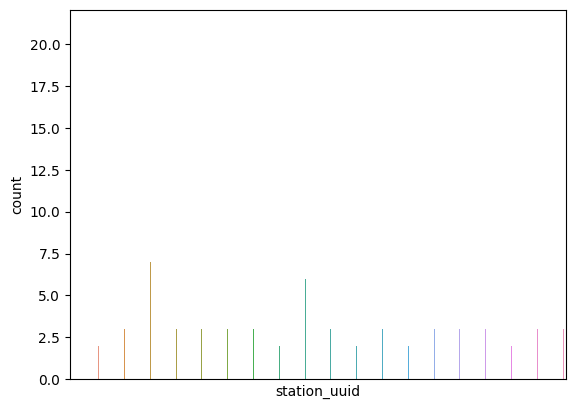

In [28]:
sns.countplot(duplicated_rn, x='station_uuid', hue='station_uuid')
plt.xticks([])
plt.legend().remove()
plt.show()

In [7]:
prices_data.query('station_uuid == "4a6773b3-2c38-453c-812b-665be4ff6c3b"')

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
15426,2021-08-09 06:31:08+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.419,1.669,0.0,1,1,0
53753,2021-08-09 09:02:06+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.469,1.719,0.0,1,1,0
92199,2021-08-09 10:46:09+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.469,1.699,0.0,0,1,0
104252,2021-08-09 11:20:08+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.469,1.679,0.0,0,1,0
112663,2021-08-09 11:48:07+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.459,1.669,0.0,1,1,0
114269,2021-08-09 11:53:07+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.439,1.669,0.0,1,0,0
115302,2021-08-09 11:58:07+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.429,1.639,0.0,1,1,0
124608,2021-08-09 12:16:08+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.469,1.679,0.0,1,1,0
150526,2021-08-09 13:36:05+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.449,1.679,0.0,1,0,0
163141,2021-08-09 14:10:06+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.449,1.669,0.0,0,1,0


In [8]:
prices_data.query('dieselchange==3 or e5change==3 or e10change==3')

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
172,2023-05-10 00:24:27+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
182,2023-05-10 00:31:57+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
195,2023-05-10 00:39:21+02,b9b395af-04c3-4150-a81b-f4dd215a20f0,1.469,4.000,0.000,0,3,0
531,2023-05-10 00:50:15+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
632,2023-05-10 00:56:15+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
...,...,...,...,...,...,...,...,...
252803,2023-05-10 23:18:14+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,1.899,1.829,0,3,0
253259,2023-05-10 23:25:12+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,1.899,1.829,0,3,0
253302,2023-05-10 23:26:14+02,b9b395af-04c3-4150-a81b-f4dd215a20f0,1.589,4.000,0.000,0,3,0
254225,2023-05-10 23:50:15+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,1.899,1.829,0,3,0


<Axes: xlabel='station_uuid', ylabel='date'>

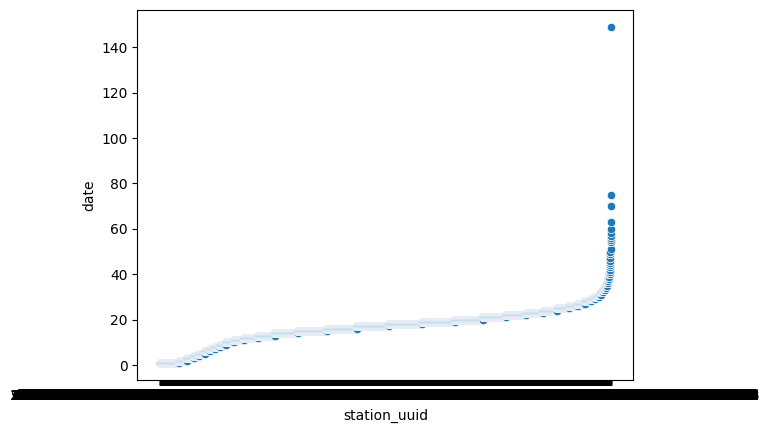

In [9]:
changes = prices_data.groupby('station_uuid').count().sort_values('date')
sns.scatterplot(changes.date)

<Axes: xlabel='date', ylabel='Count'>

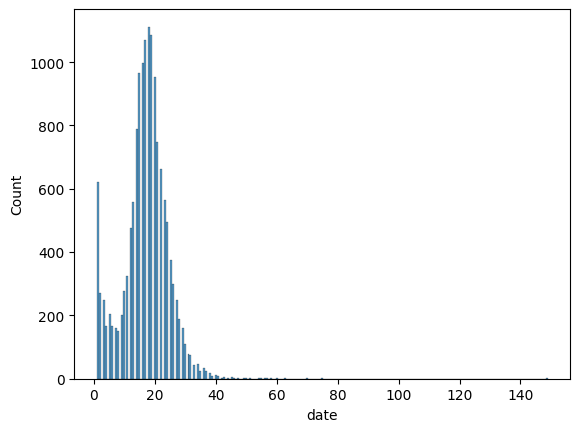

In [10]:
sns.histplot(changes.date)

In [11]:
prices_data.station_uuid.nunique()

15062

In [12]:
prices_data.query('station_uuid == "7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe"')

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
164,2023-05-10 00:21:15+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,0.000,1.699,0,2,0
172,2023-05-10 00:24:27+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
174,2023-05-10 00:28:00+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,0.000,1.699,0,2,0
182,2023-05-10 00:31:57+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
483,2023-05-10 00:47:16+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,0.000,1.699,0,2,0
...,...,...,...,...,...,...,...,...
253259,2023-05-10 23:25:12+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,1.899,1.829,0,3,0
254142,2023-05-10 23:47:13+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,0.000,1.829,0,2,0
254225,2023-05-10 23:50:15+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,1.899,1.829,0,3,0
254266,2023-05-10 23:53:14+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.629,0.000,1.829,0,2,0


<Axes: xlabel='date', ylabel='Count'>

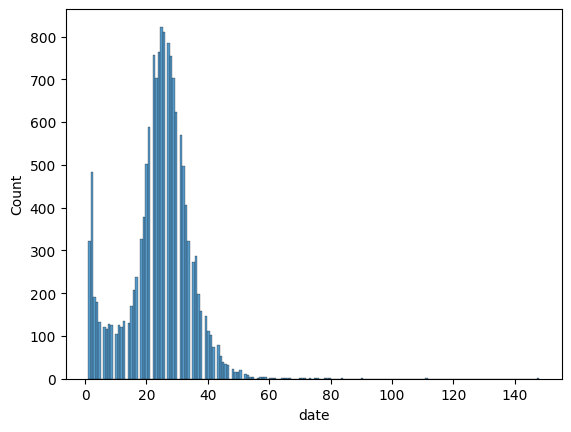

In [13]:
prices_data9 = pd.read_csv('data/prices/2023/05/2023-05-09-prices.csv')
changes = prices_data9.groupby('station_uuid').count().sort_values('date')
sns.histplot(changes.date)

In [14]:
changes

,date,diesel,e5,e10,dieselchange,e5change,e10change
station_uuid,,,,,,,
2a7ac466-b9d2-4cd3-1da7-6b769dd8b2f3,1,1,1,1,1,1,1
e9e862d5-33c6-42ae-9e92-0c09aea8b13d,1,1,1,1,1,1,1
9f44df1b-5c25-414a-98dd-261a5e1e64ba,1,1,1,1,1,1,1
2af9d112-3afe-4745-6664-85d38a982f23,1,1,1,1,1,1,1
c7d84781-a0db-440a-a222-25159211d879,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
22058993-886f-465b-bcd3-3b2d8f2f0c28,80,80,80,80,80,80,80
8d93bf21-f18e-458a-b439-3ee8ae056c7c,84,84,84,84,84,84,84
d4789266-a500-44b2-bf9f-43d1c3ee65a3,90,90,90,90,90,90,90


In [15]:
prices_data9.query('station_uuid == "7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe"')

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
190,2023-05-09 00:32:12+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.509,0.000,1.659,0,2,0
193,2023-05-09 00:35:09+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.509,1.719,1.659,0,3,0
412,2023-05-09 00:44:12+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.509,0.000,1.659,0,2,0
544,2023-05-09 00:48:13+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.509,1.719,1.659,0,3,0
670,2023-05-09 00:57:14+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.509,0.000,1.659,0,2,0
...,...,...,...,...,...,...,...,...
359920,2023-05-09 23:31:13+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
360637,2023-05-09 23:46:16+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,0.000,1.699,0,2,0
360737,2023-05-09 23:50:16+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,1.759,1.699,0,3,0
360787,2023-05-09 23:53:17+02,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,1.479,0.000,1.699,0,2,0


In [16]:
stations_data.query('uuid == "7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe"')

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
1082,7d0bc27f-a579-4cdc-bb2a-24aa2b8c8ffe,Alex Wenker & Söhne GmbH,Tankstelle Wenker,Osnabrücker Str.,277,48429,Rheine,52.28612,7.471112,2014-03-18 16:45:31+01,{}


In [17]:
prices_data.head(30)

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2023-05-10 00:00:18+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.559,1.909,0.000,0,1,0
1,2023-05-10 00:00:18+02,99820b70-3b17-4fe7-80ef-5de2fe19619f,1.889,2.039,0.000,1,1,0
2,2023-05-10 00:00:18+02,0f6e7744-39a9-4dfb-9909-81b44b85a69d,1.519,1.789,1.729,1,1,1
3,2023-05-10 00:00:18+02,ae2fea56-8527-4af7-8617-8aa3b5056ffa,1.529,1.789,1.729,0,1,1
4,2023-05-10 00:00:18+02,8b2f8add-d210-46be-ae06-143ddd4cfa08,1.629,1.869,1.809,1,1,1
5,2023-05-10 00:00:18+02,92825bd9-b322-410c-8068-ac752051922b,1.569,1.819,1.759,1,1,1
6,2023-05-10 00:00:18+02,2549304b-0429-426b-82f0-f23f72bcb65a,1.639,1.859,1.799,1,1,1
7,2023-05-10 00:00:18+02,9876c291-7600-40db-9f39-84fdabbcd66e,1.639,1.869,1.809,0,1,1
8,2023-05-10 00:00:18+02,c7b1d8f5-30d8-453c-b779-f0ffc51c8100,1.629,1.869,1.809,1,1,1
9,2023-05-10 00:00:18+02,1ea72b31-4391-454b-9ac0-603ce8c5841b,1.549,0.000,0.000,1,0,0


In [18]:
prices_data09 = pd.read_csv('data/prices/2023/05/2023-05-09-prices.csv')
prices_data09.nunique()

date             1223
station_uuid    15066
diesel            228
e5                219
e10               221
dieselchange        4
e5change            4
e10change           4
dtype: int64

In [19]:
prices_data09.groupby('date').count()

,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
date,,,,,,,
2023-05-09 00:00:14+02,18,18,18,18,18,18,18
2023-05-09 00:01:09+02,5,5,5,5,5,5,5
2023-05-09 00:02:11+02,8,8,8,8,8,8,8
2023-05-09 00:03:16+02,6,6,6,6,6,6,6
2023-05-09 00:04:12+02,35,35,35,35,35,35,35
...,...,...,...,...,...,...,...
2023-05-09 23:55:12+02,8,8,8,8,8,8,8
2023-05-09 23:56:14+02,16,16,16,16,16,16,16
2023-05-09 23:57:14+02,7,7,7,7,7,7,7


In [20]:
prices_data09.head(20)

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2023-05-09 00:00:14+02,99820b70-3b17-4fe7-80ef-5de2fe19619f,1.889,2.029,0.000,1,1,0
1,2023-05-09 00:00:14+02,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.559,1.899,0.000,0,1,0
2,2023-05-09 00:00:14+02,63966218-4f62-4e4b-ab40-dd6021704677,1.549,0.000,0.000,1,0,0
3,2023-05-09 00:00:14+02,e9a590a0-ec5f-4e2e-b82f-0379f9ccaecc,1.549,1.819,1.759,1,1,1
4,2023-05-09 00:00:14+02,d3ef2892-11b5-4032-adf9-13cf2206f726,1.739,1.929,1.869,1,1,1
5,2023-05-09 00:00:14+02,eec42f8a-ea6f-4e11-9eb2-b134c5269c37,1.619,1.859,1.799,1,1,1
6,2023-05-09 00:00:14+02,dfe3bd39-83cd-43b9-8628-f09896331b19,1.539,1.779,1.719,1,1,1
7,2023-05-09 00:00:14+02,6c278842-028e-47c1-b9e4-98a951dff90a,1.609,1.879,0.000,1,1,0
8,2023-05-09 00:00:14+02,2e7585c3-f13e-43b9-04a1-15b2fb99455e,1.559,1.819,1.759,1,1,1
9,2023-05-09 00:00:14+02,2b91e044-603e-450f-bcab-e7553a500ffd,1.719,1.919,1.859,1,1,1


In [21]:


prices_data09 = prices_data09.assign(
    date = lambda x: pd.to_datetime(x['date']),
    year = lambda x: x['date'].dt.year,
    month = lambda x: x['date'].dt.month,
    day = lambda x: x['date'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear,
    weekday = lambda x: x['date'].dt.dayofweek,
    hour = lambda x: x['date'].dt.hour,
)

display(prices_data09.info())
display(prices_data09.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360858 entries, 0 to 360857
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype                    
---  ------        --------------   -----                    
 0   date          360858 non-null  datetime64[ns, UTC+02:00]
 1   station_uuid  360858 non-null  object                   
 2   diesel        360858 non-null  float64                  
 3   e5            360858 non-null  float64                  
 4   e10           360858 non-null  float64                  
 5   dieselchange  360858 non-null  int64                    
 6   e5change      360858 non-null  int64                    
 7   e10change     360858 non-null  int64                    
 8   year          360858 non-null  int32                    
 9   month         360858 non-null  int32                    
 10  day           360858 non-null  int32                    
 11  dayofyear     360858 non-null  int32                    
 12  weekday       36

None

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change,year,month,day,dayofyear,weekday,hour
0,2023-05-09 00:00:14+02:00,99820b70-3b17-4fe7-80ef-5de2fe19619f,1.889,2.029,0.000,1,1,0,2023,5,9,129,1,0
1,2023-05-09 00:00:14+02:00,4a6773b3-2c38-453c-812b-665be4ff6c3b,1.559,1.899,0.000,0,1,0,2023,5,9,129,1,0
2,2023-05-09 00:00:14+02:00,63966218-4f62-4e4b-ab40-dd6021704677,1.549,0.000,0.000,1,0,0,2023,5,9,129,1,0
3,2023-05-09 00:00:14+02:00,e9a590a0-ec5f-4e2e-b82f-0379f9ccaecc,1.549,1.819,1.759,1,1,1,2023,5,9,129,1,0
4,2023-05-09 00:00:14+02:00,d3ef2892-11b5-4032-adf9-13cf2206f726,1.739,1.929,1.869,1,1,1,2023,5,9,129,1,0
5,2023-05-09 00:00:14+02:00,eec42f8a-ea6f-4e11-9eb2-b134c5269c37,1.619,1.859,1.799,1,1,1,2023,5,9,129,1,0
6,2023-05-09 00:00:14+02:00,dfe3bd39-83cd-43b9-8628-f09896331b19,1.539,1.779,1.719,1,1,1,2023,5,9,129,1,0
7,2023-05-09 00:00:14+02:00,6c278842-028e-47c1-b9e4-98a951dff90a,1.609,1.879,0.000,1,1,0,2023,5,9,129,1,0
8,2023-05-09 00:00:14+02:00,2e7585c3-f13e-43b9-04a1-15b2fb99455e,1.559,1.819,1.759,1,1,1,2023,5,9,129,1,0
9,2023-05-09 00:00:14+02:00,2b91e044-603e-450f-bcab-e7553a500ffd,1.719,1.919,1.859,1,1,1,2023,5,9,129,1,0


In [26]:
np.random.seed(42)

active_stations = prices_data09.station_uuid.unique()
active_stations_sample = np.random.choice(active_stations, size=100)
pds = prices_data09.query('station_uuid in @active_stations_sample')
pds

timestamps = pd.Series(pds.date.unique(), name='date')
stations = pd.Series(pds.station_uuid.unique(), name='station_uuid')


# create a table that carries all stations for each hour of the day

# group by the hour of the day, take the average price if a station is occuring more than once during that time

# if a station occurs, check the *change columns if its a 2 or a 3, and if yes, check if the price is actually different from the previous hour of if prices have just been re-reported

# if prices changed then make a 1 in the price-changed-dummies

# if there are multiple occurences of the same station within one hour, check which prices changed and make en entry for the respective dummy

# if there are multiple occurences of the same station within one hour, for each of the 3 fuel prices, count how often it changed

# take a batch for each hour of the day

# check 

df = pd.merge(timestamps, stations, how='cross')
df = pd.merge(df, pds, how='left', on=['date', 'station_uuid']).set_index(['date', 'station_uuid'])

df.query('hour==3')

diesel     e5   
date                      station_uuid                                          
2023-05-09 03:43:08+02:00 4e49e411-d4ba-4c7c-990b-595bafeef7c5   1.549  1.789  \
                          1dc632bf-90c5-4971-8420-a74a842203c1   1.529  1.819   
                          9bf87492-08f9-479f-9f91-8779645552fc   1.554  1.744   
                          16e6477d-7796-4084-9330-b60ea4a1b629   1.549  1.799   
                          8bfd2b19-cc2c-4522-aab2-ab3fb2691807   1.559  1.799   
...                                                                ...    ...   
                          ebfed486-9666-44ec-9dc4-ec474a9d5c1c   1.649  1.899   
                          6eaab5b6-646e-4439-81fc-ce5005259a15   1.549  1.779   
                          2617b945-a09e-4b43-81f3-e369a3b2229a   1.609  1.869   
                          33af1490-3940-491c-9ec4-844e6830b799   1.579  0.000   
                          a68a828f-2673-4df3-b851-82e8022b1511   1.619  1.869   

                                                                  e10   
date                      station_uuid                                  
2023-05-09 03:43:08+02:00 4e49e411-d4ba-4c7c-990b-595bafeef7c5  1.729  \
                          1dc632bf-90c5-4971-8420-a74a842203c1  1.759   
                          9bf87492-08f9-479f-9f91-8779645552fc  1.714   
                          16e6477d-7796-4084-9330-b60ea4a1b629  1.739   
                          8bfd2b19-cc2c-4522-aab2-ab3fb2691807  1.739   
...                                                               ...   
                          ebfed486-9666-44ec-9dc4-ec474a9d5c1c  1.839   
                          6eaab5b6-646e-4439-81fc-ce5005259a15  1.719   
                          2617b945-a09e-4b43-81f3-e369a3b2229a  1.809   
                          33af1490-3940-491c-9ec4-844e6830b799  0.000   
                          a68a828f-2673-4df3-b851-82e8022b1511  1.809   

                                                                dieselchange   
date                      station_uuid                                         
2023-05-09 03:43:08+02:00 4e49e411-d4ba-4c7c-990b-595bafeef7c5           3.0  \
                          1dc632bf-90c5-4971-8420-a74a842203c1           3.0   
                          9bf87492-08f9-479f-9f91-8779645552fc           3.0   
                          16e6477d-7796-4084-9330-b60ea4a1b629           3.0   
                          8bfd2b19-cc2c-4522-aab2-ab3fb2691807           3.0   
...                                                                      ...   
                          ebfed486-9666-44ec-9dc4-ec474a9d5c1c           3.0   
                          6eaab5b6-646e-4439-81fc-ce5005259a15           3.0   
                          2617b945-a09e-4b43-81f3-e369a3b2229a           3.0   
                          33af1490-3940-491c-9ec4-844e6830b799           3.0   
                          a68a828f-2673-4df3-b851-82e8022b1511           3.0   

                                                                e5change   
date                      station_uuid                                     
2023-05-09 03:43:08+02:00 4e49e411-d4ba-4c7c-990b-595bafeef7c5       3.0  \
                          1dc632bf-90c5-4971-8420-a74a842203c1       3.0   
                          9bf87492-08f9-479f-9f91-8779645552fc       3.0   
                          16e6477d-7796-4084-9330-b60ea4a1b629       3.0   
                          8bfd2b19-cc2c-4522-aab2-ab3fb2691807       3.0   
...                                                                  ...   
                          ebfed486-9666-44ec-9dc4-ec474a9d5c1c       3.0   
                          6eaab5b6-646e-4439-81fc-ce5005259a15       3.0   
                          2617b945-a09e-4b43-81f3-e369a3b2229a       3.0   
                          33af1490-3940-491c-9ec4-844e6830b799       0.0   
                          a68a828f-2673-4df3-b851-82e8022b1511       3.0   

                              

In [ ]:
# a function that carries over the last reported price of the previous day